In [1]:
import numpy as np
import cv2 as cv
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import mrob

from arucoprocessor import ArucoProcessor
import tools

In [3]:
buf = tools.video_to_nparray('../videos/ISR_lab_with_ArUco.mp4')

In [4]:
# Extraction of ORB features and detection of ArUco poses
# for initialization

orb = cv.ORB_create(nfeatures=500)
bf = cv.BFMatcher(cv.NORM_HAMMING)
apc = ArucoProcessor()

keyframe_index = 0
frame_index = 0

keyframes = []
detected_arucos = []

initialization = True

for frame_index in tqdm(range(buf.shape[0])):
    
    frame = buf[frame_index]
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    if initialization:
        see_arucos = apc.process_frame(gray)
    if frame_index > 150 and initialization:
        initialization = False

    kp, des = orb.detectAndCompute(gray,None)

    if frame_index == 0:
        keyframe_kp = kp
        keyframe_des = des
        keyframe_img = gray
        keyframe_index = frame_index
        keyframes.append((keyframe_index, keyframe_kp, keyframe_img))

    if frame_index != 0:

        matches = bf.knnMatch(prev_des, des, k=2)
        keyframe_matches = bf.knnMatch(keyframe_des, des, k=2)

        good = []
        for m,n in keyframe_matches:
            if m.distance < 0.7*n.distance:
                good.append(m)

        if initialization and see_arucos:
            if frame_index-keyframe_index > 15 or len(good) < 100:
                keyframe_kp = kp
                keyframe_des = des
                keyframe_index = frame_index
                keyframe_img = gray
                keyframes.append((keyframe_index, keyframe_kp, keyframe_img, good))
                detected_arucos.append((keyframe_index, apc.get_pose_wrt_aruco(), apc.get_corners()))
        else:
            if len(good) < 100:
                keyframe_kp = kp
                keyframe_des = des
                keyframe_index = frame_index
                keyframe_img = gray
                keyframes.append((keyframe_index, keyframe_kp, keyframe_img, good))

    prev_kp = kp
    prev_des = des
    prev_img = gray

cv.destroyAllWindows()

  0%|          | 0/410 [00:00<?, ?it/s]

  1%|          | 3/410 [00:01<02:12,  3.06it/s]

Reliable


100%|██████████| 410/410 [00:26<00:00, 15.23it/s]


In [5]:
len(keyframes)

33

In [6]:
# Matching of keypoints among several consequent keyframes

global_matches = []

for m in range(len(keyframes[1][3])):
    global_matches.append([keyframes[1][3][m].queryIdx, keyframes[1][3][m].trainIdx])

for kf in tqdm(range(2, len(keyframes))):
    for m in range(len(keyframes[kf][3])):
        found_match = False
        for global_match in global_matches:
            if global_match[-1] == keyframes[kf][3][m].queryIdx and len(global_match) != kf+1:
                global_match.append(keyframes[kf][3][m].trainIdx)
                found_match = True
        if not found_match:
            global_matches.append([-1] * (kf - 1) + [keyframes[kf][3][m].queryIdx, keyframes[kf][3][m].trainIdx])
            
    for global_match in global_matches:
        if len(global_match) < kf + 1:
            global_match.extend([-1])

assert len(keyframes) == min([len(x) for x in global_matches]) == max([len(x) for x in global_matches])

global_matches = np.array(global_matches)

  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:01<00:00, 17.61it/s]


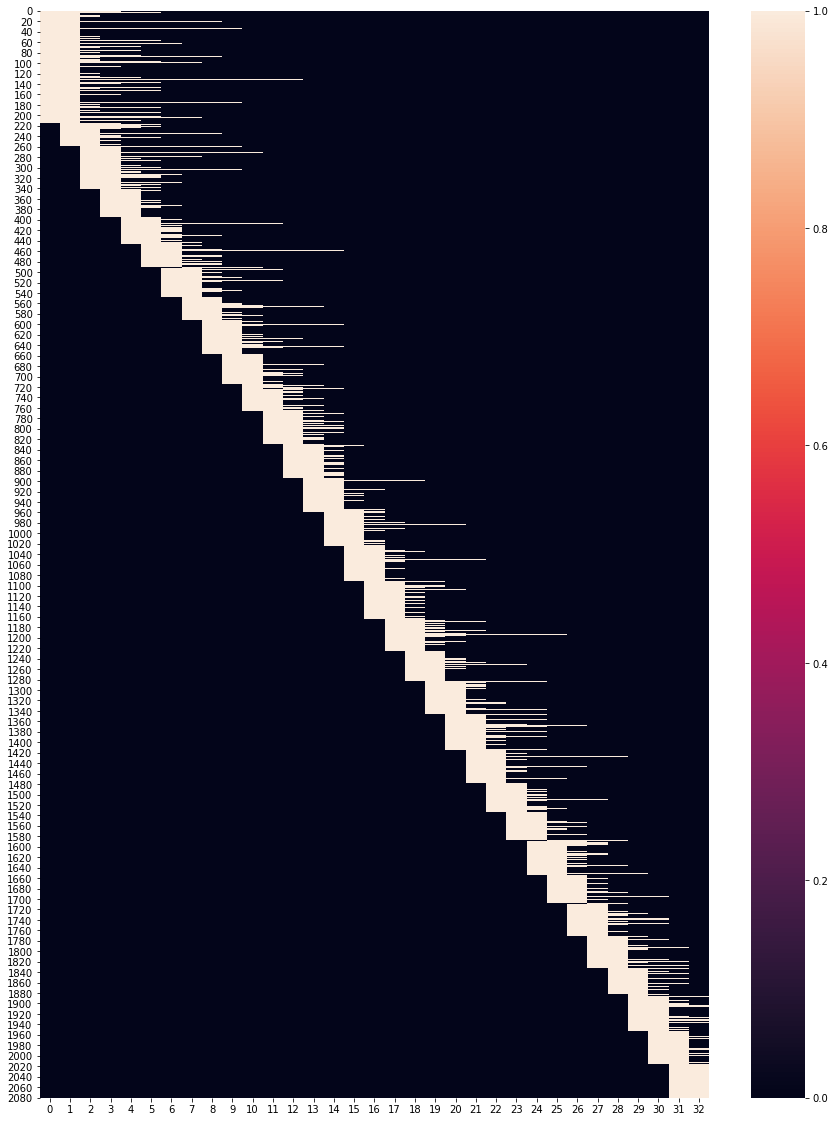

In [7]:
plt.figure(figsize=(15, 20))
sns.heatmap(np.where(global_matches > 0, 1, 0));

In [8]:
# Camera and ArUco parameters 
 
W = np.identity(2)

K = np.array([[1.23472227e+03, 0.00000000e+00, 6.38814655e+02],
              [0.00000000e+00, 1.23122213e+03, 3.37257425e+02],
              [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

camera_k = np.array([K[0, 0],
                     K[1, 1],
                     K[0, 2],
                     K[1, 2]])

marker_size = 0.144

marker_points = np.array([[-marker_size / 2, -marker_size / 2, 0],
                          [ marker_size / 2, -marker_size / 2, 0],
                          [ marker_size / 2,  marker_size / 2, 0],
                          [-marker_size / 2,  marker_size / 2, 0]])

In [9]:
# Graph optimization

graph = mrob.FGraph(mrob.CAUCHY)

global_matches_to_graph_id = {}
corners_to_graph_id = {}

poses_indeces_in_graph = []
last_position = np.zeros((3, 1))

for angle in range(4):
    l = graph.add_node_landmark_3d(marker_points[angle], mrob.NODE_ANCHOR)
    corners_to_graph_id[angle] = l

for kf in tqdm(range(len(keyframes))):

    if len(detected_arucos) > kf:

        pose_id = graph.add_node_pose_3d(mrob.geometry.SE3())

        graph.add_factor_1pose_3d(mrob.geometry.SE3(detected_arucos[kf][1]), pose_id, np.diag((0.1, 0.1, 0.1, 0.4, 0.4, 0.4)))

        for angles in range(4):
            graph.add_factor_camera_proj_3d_point(
                obs = detected_arucos[kf][2][angle],
                nodePoseId = pose_id,
                nodeLandmarkId = corners_to_graph_id[angle],
                camera_k = camera_k,
                obsInvCov = W)

    else:
        pose_id = graph.add_node_pose_3d(mrob.geometry.SE3(last_pose))

    poses_indeces_in_graph.append(pose_id)
    
    for global_match_index in range(global_matches.shape[0]):

        if global_matches[global_match_index, kf] == -1:
            continue
        
        if not (global_match_index in global_matches_to_graph_id.keys()):
            l = graph.add_node_landmark_3d(last_position + np.array([[0], [0], [0.5]]) + np.array([[keyframes[kf][1][global_matches[global_match_index, kf]].pt[0] * 3 / camera_k[0]], [keyframes[kf][1][global_matches[global_match_index, kf]].pt[1] * 3 / camera_k[1]], [3]]))
            global_matches_to_graph_id[global_match_index] = l
            
        graph.add_factor_camera_proj_3d_point(
                obs = keyframes[kf][1][global_matches[global_match_index, kf]].pt,
                nodePoseId = pose_id,
                nodeLandmarkId = global_matches_to_graph_id[global_match_index],
                camera_k = camera_k,
                obsInvCov = W)
    
    graph.solve(method=mrob.LM, maxIters=200)
    last_pose = graph.get_estimated_state()[pose_id]
    last_position = last_pose[0:3, 3:]

100%|██████████| 33/33 [02:03<00:00,  3.74s/it]


In [10]:
# Extracting landmark positions and camera poses from the graph

graph_state = graph.get_estimated_state()
landmarks_3d = np.array([x for x in np.array(graph_state)[list(global_matches_to_graph_id.values())]]).reshape(-1, 3)
camera_poses = np.array([x for x in np.array(graph_state)[poses_indeces_in_graph]])

<ipython-input-10-0d5774be683c>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  landmarks_3d = np.array([x for x in np.array(graph_state)[list(global_matches_to_graph_id.values())]]).reshape(-1, 3)
<ipython-input-10-0d5774be683c>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  camera_poses = np.array([x for x in np.array(graph_state)[poses_indeces_in_graph]])


In [14]:
fig = tools.plot_data(camera_poses, landmarks_3d, marker_points, window=20, arrows_length=0.3)

In [12]:
# Evaluation of covariance of the final pose
  
from scipy.sparse.linalg import inv

est_state = graph.get_estimated_state()
cov_matrix = inv(graph.get_information_matrix()).todense()

lengths = []
for i in range(len(est_state)):
    if len(est_state[i]) == 3:
        lengths.append(3)            # position covariance shape
    elif len(est_state[i]) == 4:     # SE3 shape
        lengths.append(6)            # ln(SE3) covariance shape

lengths = np.array(lengths)     
cumulative_indeces = np.cumsum(lengths)

lower_index_last_pose = cumulative_indeces[poses_indeces_in_graph[-1] - 1] - 12
upper_index_last_pose = cumulative_indeces[poses_indeces_in_graph[-1]    ] - 12

last_pose_cov = cov_matrix[lower_index_last_pose:upper_index_last_pose, \
                           lower_index_last_pose:upper_index_last_pose]

In [13]:
print('Final position:')
print(last_position.flatten())

print('3 * standard deviation of the final position:')
print(3 * np.sqrt(np.diag(last_pose_cov)[:3]))

Final position:
[-2.72063414 -1.86560805  7.47124253]
3 * standard deviation of the final position:
[0.00186667 0.00117016 0.00146961]
